## VAE
SoftCVI gives an approach for fitting the parameters of the variational distribution $\phi$. However, in some contexts, the model may be defined as $p_{\psi}(\theta, x_{\text{obs}})$, with $\psi$, being a set of model parameters which we wish to optimize in some manner alongside $\phi$. SoftCVI does not directly provide a method for fitting the model parameters $\psi$, but we can adapt the objective to train $\psi$ to (approximately) maximize the marginal likelihood.
\begin{align}
    \mathcal{L}(\phi, \psi; \{\theta_k\}_{k=1}^{K}, y) = \mathcal{L}_{\text{SoftCVI}}(\phi; \{\theta_k\}_{k=1}^{K}, y) -\frac{1}{K}\sum_{i=1}^K \log p_{\psi}(\theta, x_{\text{obs}}).
\end{align}
where we can view the second term as the component of the ELBO corresponding to the model parameters. This approach is supported in by setting ``elbo_optimize_model=True`` to the objective. Due to the disjoint parameter sets between the objectives, in addition to the invariance of common optimizers such a Adam to diagonal rescaling of gradient elements, adding the objectives often works well without the need for e.g. considering the relative objective weights. As an example, we will train a variational autoencoder, where $\psi$ includes the parameters of the decoder in addition to the models prior parameters, and $\phi$ consists of the parameters of the encoder.

In [1]:
import os
from collections.abc import Callable

import equinox as eqx
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import numpyro.distributions as dist
import optax
from flowjax import wrappers
from flowjax.distributions import AbstractDistribution, Normal
from flowjax.experimental.numpyro import sample
from flowjax.train.train_utils import step
from jax.nn import relu, sigmoid, softplus
from jaxtyping import Array
from numpyro.examples.datasets import MNIST, load_dataset
from pyrox.program import AbstractProgram, SetKwargs
from pyrox import losses
from scipy.stats import norm
from tqdm import trange

from softcvi_validation import utils


os.chdir(utils.get_abspath_project_root())
plt.style.use('./plots/style.mplstyle')


class Encoder(eqx.Module):
    layers: tuple
    z_dim: int

    def __init__(self, key, z_dim: int):
        keys = jr.split(key, 4)
        self.layers = (
            lambda x: x.reshape(28*28),
            eqx.nn.Linear(28*28, 500, key=keys[1]),
            relu,
            eqx.nn.Linear(500, 250, key=keys[2]),
            relu,
            eqx.nn.Linear(250, z_dim*2, key=keys[3]),
        )
        self.z_dim = z_dim

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Decoder(eqx.Module):
    z_dim: int
    layers: tuple

    def __init__(self, key, z_dim: int):
        keys = jr.split(key, 4)
        self.layers = (
            eqx.nn.Linear(z_dim, 250, key=keys[0]),
            relu,
            eqx.nn.Linear(250, 500, key=keys[1]),
            relu,
            eqx.nn.Linear(500, 28*28, key=keys[2]),
            lambda x: x.reshape(1, 28, 28),
            sigmoid,
        )
        self.z_dim = z_dim

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    
class VAEModel(AbstractProgram):
    decoder: Callable
    prior_dist: AbstractDistribution
    
    def __init__(self, decoder: Callable):
        self.decoder = decoder
        self.prior_dist = Normal(jnp.zeros(self.decoder.z_dim))

    def __call__(self, *, obs: Array | None = None):
        z = sample("z", self.prior_dist)
        img_loc = self.decoder(z)
        return sample("x", dist.Bernoulli(img_loc), obs=obs)


class VAEGuide(AbstractProgram):
    encoder: Callable

    def __init__(self, encoder: Callable):
        self.encoder = encoder

    def __call__(self, *, obs):
        z_loc, z_scales = jnp.split(self.encoder(obs), 2)
        z_scales = softplus(z_scales)
        return sample("z", Normal(z_loc, z_scales))


/home/dw16200/miniconda3/envs/pyrox_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
z_dim = 2
steps=100000  # Reasonable results can be seen in e.g. 10K iterations

key, subkey = jr.split(jr.key(0))

encoder = Encoder(
    key=subkey,
    z_dim=z_dim,
)

key, subkey = jr.split(jr.key(0))
decoder = Decoder(subkey, z_dim=2)


model =  VAEModel(decoder)
guide = VAEGuide(encoder=encoder)

train_init, train_fetch = load_dataset(
    MNIST, batch_size=None, split="train",
)
obs = train_fetch()[0]


def fit(key, model, guide, loss_fn, obs):
        
    params, static = eqx.partition(
        (model, guide),
        eqx.is_inexact_array,
        is_leaf=lambda leaf: isinstance(leaf, wrappers.NonTrainable),
    )

    optimizer = optax.adam(2e-4)
    opt_state = optimizer.init(params)

    @eqx.filter_jit
    def wrapped_loss(params, static, key):  # To support sampling and passing obs
        obs_key, loss_key = jr.split(key)
        obs_i = jr.choice(obs_key, obs, (1,))
        params = SetKwargs(params[0], obs=obs_i), SetKwargs(params[1], obs=obs_i)
        static = SetKwargs(static[0], obs=obs_i), SetKwargs(static[1], obs=obs_i)
        return loss_fn(params, static, loss_key)


    loss_vals = []
    for _ in trange(steps):
        key, subkey = jr.split(key)
        params, opt_state, loss_val = step(
            params,
            static,
            subkey,
            optimizer=optimizer,
            opt_state=opt_state,
            loss_fn=wrapped_loss,
        )
        loss_vals.append(loss_val)

    return eqx.combine(params, (model, guide)), loss_vals

In [3]:

loss_choices = {
   "ELBO": losses.EvidenceLowerBoundLoss(n_particles=2),
    "SoftCVI": losses.SoftContrastiveEstimationLoss(
        n_particles=2,
        alpha=0.75,
        elbo_optimize_model=True,
        ),
}

results = {}
for label, loss_fn in loss_choices.items():
    results[label] = fit(key, model, guide, loss_fn, obs)

100%|██████████| 100000/100000 [15:54<00:00, 104.81it/s]


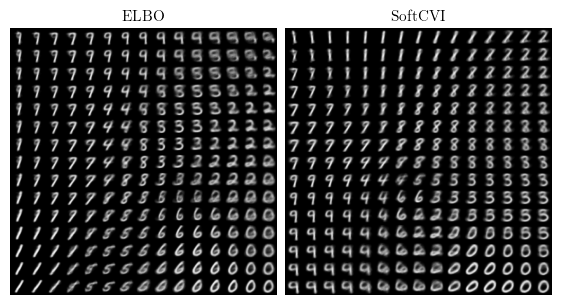

In [4]:
# Set the number of plots
plot_num = 15  # plot_num * plot_num

fig = plt.figure(
    figsize=(plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][0]/1.8),
    layout="constrained",
)

axes = fig.subplots(ncols=2)

for (label, result), ax in zip(results.items(), axes, strict=True):

    z = norm.ppf(jnp.linspace(0.1, 0.9, plot_num))
    z1, z2 = jnp.meshgrid(z, z)

    z_grid = jnp.stack([z1.ravel(), z2.ravel()], axis=-1)
    z_grid = jax.vmap(result[0][0].prior_dist.bijection.transform)(z_grid)

    # Initialize a list to store each row of images
    image_rows = []

    for row in range(plot_num):
        row_images = []
        for col in range(plot_num):
            z = z_grid[row * plot_num + col]
            img = result[0][0].decoder(z).reshape(28, 28)
            row_images.append(img)
        image_rows.append(jnp.concatenate(row_images, axis=1))
    final_image = jnp.concatenate(image_rows, axis=0)

    ax.imshow(final_image, cmap="gray")
    ax.axis('off')

    ax.set_title(label)

fig.savefig("./plots/mnist_latent_grid.pdf")
